In [1]:
# The idea is to use nWindows (say 3), and look at dependency upon sorting by window_mean.

# Note that key_1.csv shows that we are supposed to predict about 2 months worth of future data based on data
# lasting from 2015-07-01 to 2016-12-31.

In [2]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.model_selection import (train_test_split, cross_val_score)
from sklearn.preprocessing import (PolynomialFeatures, FunctionTransformer, StandardScaler)
from sklearn.pipeline import (make_pipeline, make_union, Pipeline, FeatureUnion)
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.neural_network import MLPRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor

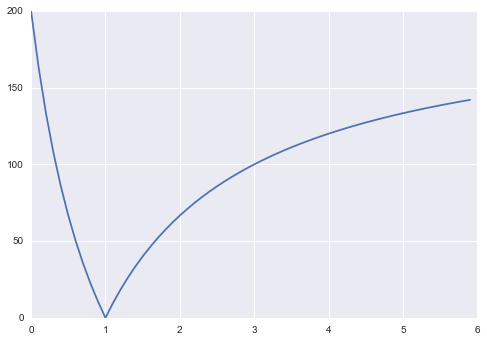

In [3]:
# Reference for performace measured by reference function. For a term |y_test - y_predict| / (|y_test| + |y_predict|) * 2 * 100,
# we look at when y_predict = alpha * y_test. Look at term as a function of alpha.

alpha = np.arange(0.0, 6.0, 0.1)
num = np.abs(1 - alpha)
denom = 1 + np.abs(alpha)
smapeVals = num / denom * 2 * 100

plt.plot(alpha, smapeVals)
plt.show()

In [4]:
all_df = pd.read_csv('train_1.csv')
all_df.shape

(145063, 551)

In [5]:
# For now, just set all NaN to 0.

all_df.fillna(0, inplace = True)

In [6]:
urlRegEx = '[^._]+[.]\w*wiki\w*[.][^_]+'

# Extract info from page

pageInfo = []

for pageStr in all_df.Page.values:
    midSplit = re.split('[_](' + urlRegEx + ')[_]', pageStr)
    thisPageInfo = midSplit[:2]
    midSplit = re.split('[_]', midSplit[2])
    thisPageInfo.extend(midSplit)
    
    pageInfo.append(thisPageInfo)
    
# Do a transpose, now in shape nInfo, nSamples

pageInfo = [[pageInfo[j][i] for j in range(len(pageInfo))] for i in range(len(pageInfo[0]))]

toInfoIndex = {'name' : 0, 'project' : 1, 'access' : 2, 'agent' : 3}
colNames = ['name', 'project', 'access', 'agent']

# Convert info to numerical

for i in range(1, 4):
    name = colNames[i]
    infoCol = np.array(pageInfo[i])
    infoCol_vals = np.unique(infoCol)
    infoCol_map = dict(zip(infoCol_vals, np.arange(len(infoCol_vals))))
    infoCol = [infoCol_map[x] for x in infoCol]
    all_df.insert(i, name, infoCol)

all_df.insert(1, 'name', pageInfo[0])
all_df[:3]

,Page,name,project,access,agent,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,...,2016-12-22,2016-12-23,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31
0,2NE1_zh.wikipedia.org_all-access_spider,2NE1,9,0,3,18.0,11.0,5.0,13.0,14.0,...,32.0,63.0,15.0,26.0,14.0,20.0,22.0,19.0,18.0,20.0
1,2PM_zh.wikipedia.org_all-access_spider,2PM,9,0,3,11.0,14.0,15.0,18.0,11.0,...,17.0,42.0,28.0,15.0,9.0,30.0,52.0,45.0,26.0,20.0
2,3C_zh.wikipedia.org_all-access_spider,3C,9,0,3,1.0,0.0,1.0,1.0,0.0,...,3.0,1.0,1.0,7.0,4.0,4.0,6.0,3.0,4.0,17.0


In [7]:
# Check if name contains a 4 digit number, perhaps related to name containing a year.

hasFourDigit = []
for name in all_df['name']:
    thisHave = re.match(r'(\b|\D)\d\d\d\d(\b|\D)', name)
    if thisHave == None:
        hasFourDigit.append(0)
    else:
        hasFourDigit.append(1)
        
all_df.insert(5, 'nameHasYear', hasFourDigit)

all_df[:3]

,Page,name,project,access,agent,nameHasYear,2015-07-01,2015-07-02,2015-07-03,2015-07-04,...,2016-12-22,2016-12-23,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31
0,2NE1_zh.wikipedia.org_all-access_spider,2NE1,9,0,3,0,18.0,11.0,5.0,13.0,...,32.0,63.0,15.0,26.0,14.0,20.0,22.0,19.0,18.0,20.0
1,2PM_zh.wikipedia.org_all-access_spider,2PM,9,0,3,0,11.0,14.0,15.0,18.0,...,17.0,42.0,28.0,15.0,9.0,30.0,52.0,45.0,26.0,20.0
2,3C_zh.wikipedia.org_all-access_spider,3C,9,0,3,0,1.0,0.0,1.0,1.0,...,3.0,1.0,1.0,7.0,4.0,4.0,6.0,3.0,4.0,17.0


In [8]:
futureT = 64

X_all = all_df.drop(['Page', 'name'], axis = 1).values[:, :-futureT]
Y_all = all_df.drop(['Page', 'name'], axis = 1).values[:, -futureT:]

In [9]:
X_trainvalid, X_test, Y_trainvalid, Y_test = train_test_split(X_all, Y_all, test_size = 0.33, random_state = 32)
X_train, X_valid, Y_train, Y_valid = train_test_split(X_trainvalid, Y_trainvalid, test_size = 0.33, random_state = 35)

print('X_train.shape = ', X_train.shape, '\tX_valid.shape = ', X_valid.shape, '\tX_test.shape = ', X_test.shape)
print('Y_train.shape = ', Y_train.shape, '\tY_valid.shape = ', Y_valid.shape, '\tY_test.shape = ', Y_test.shape)

X_train.shape =  (65118, 490) 	X_valid.shape =  (32074, 490) 	X_test.shape =  (47871, 490)
Y_train.shape =  (65118, 64) 	Y_valid.shape =  (32074, 64) 	Y_test.shape =  (47871, 64)


In [10]:
def smape(Y_predict, Y_test):
    result = np.linalg.norm(Y_predict - Y_test, axis = 1)
    result = np.abs(result)
    denom = np.linalg.norm(Y_predict, axis = 1)
    denom += np.linalg.norm(Y_test, axis = 1)
    result /= denom
    result *= 100 * 2
    result = np.mean(result)
    return result

def smape_scorer(estimator, X, Y):
    Ypredict = estimator.predict(X)
    result = smape(Y, Ypredict)
    return -result

def window_means(X, nWindows, windowSize):
    nSamples, nTimes = X.shape
    means = np.empty((nSamples, 0))
    for i in range(nWindows):
        newCol = X[:, nTimes - 1 - (i+1) * windowSize : nTimes - 1 - i * windowSize].mean(axis = 1, keepdims = True)
        means = np.hstack((means, newCol))
    return means

def all_window_features(X, nWindows, windowSize):
    nSamples, nTimes = X.shape
    features = window_means(X, nWindows, windowSize)
    linear = np.empty((nSamples, 0))
    
    # Make linear and quadratic arrays orthogonal to each other.
    const = np.full(windowSize, 1 / np.sqrt(windowSize))
    lin = np.arange(windowSize) - (windowSize - 1) / 2
    
    for i in range(nWindows):
        X_window = X[:, nTimes - 1 - (i + 1)*windowSize : nTimes - 1 - i * windowSize]
        newCol = np.dot(X_window, lin).reshape(-1,1)
        features = np.hstack((features, newCol))
        
    return features

def all_features(X, nWindows, windowSize):
    features = X[:, 0:4]
    window_feat = all_window_features(X[:, 4:], nWindows, windowSize)
    features = np.hstack((features, window_feat))
    return features
    

In [ ]:
# Let's try decision tree on different window means.

def Ztransform(Y, param):
    return np.log(param + Y)

def inverseZ(Z, param):
    return -param + np.exp(Z)

param = 15
Z_train = Ztransform(Y_train, param)
Z_valid = Ztransform(Y_valid, param)

model = Pipeline([ ('means', FunctionTransformer(window_means, kw_args = {'nWindows' : 3, 'windowSize' : 150})),
                   ('tree', DecisionTreeRegressor(max_depth = 10)) ])
model.fit(X_train, Z_train)
Z_predict = model.predict(X_valid)
Y_predict = inverseZ(Z_predict, param)
print('smape = ', smape(1e-6 + Y_predict, Y_valid))

In [ ]:
# Let's try parameter search.

param_search = np.arange(1, 30, 3)
smapes = []
for param in param_search:
    Z_train = Ztransform(Y_train, param)
    Z_valid = Ztransform(Y_valid, param)
    model.fit(X_train, Z_train)
    Z_predict = model.predict(X_valid)
    Y_predict = inverseZ(Z_predict, param)
    newsmape = smape(1e-6 + Y_predict, Y_valid)
    print('param', param, '\tsmape = ', newsmape, end = '')
    smapes.append(newsmape)
plt.plot(param_search, smapes)
plt.show()

In [ ]:
# Let's try parameter search.

depth_search = np.arange(7, 13, 1)
param = 16
smapes = []
for depth in depth_search:
    Z_train = Ztransform(Y_train, param)
    Z_valid = Ztransform(Y_valid, param)
    model.set_params(tree__max_depth = depth)
    model.fit(X_train, Z_train)
    Z_predict = model.predict(X_valid)
    Y_predict = inverseZ(Z_predict, param)
    newsmape = smape(1e-6 + Y_predict, Y_valid)
    print('depth', depth, '\tsmape = ', newsmape, end = '')
    smapes.append(newsmape)
plt.plot(depth_search, smapes)
plt.show()

In [ ]:
# Let's try decision tree on different window means.

def Ztransform(Y, param):
    return np.log(param + Y)

def inverseZ(Z, param):
    return -param + np.exp(Z)

param = 15
Z_train = Ztransform(Y_train, param)
Z_valid = Ztransform(Y_valid, param)
print(Z_train.shape, X_train.shape, Z_valid.shape)

model = Pipeline([ ('drop', FunctionTransformer(lambda X : X[:, 3:])),
                   ('means', FunctionTransformer(all_window_features, kw_args = {'nWindows' : 3, 'windowSize' : 150})),
                   ('tree', DecisionTreeRegressor(max_depth = 10)) ])
model.fit(X_train, Z_train)
Z_predict = model.predict(X_valid)
Y_predict = inverseZ(Z_predict, param)
print('smape = ', smape(1e-6 + Y_predict, Y_valid))

In [12]:
# Let's try decision tree on different window means.

def Ztransform(Y, param):
    return np.log(param + Y)

def inverseZ(Z, param):
    return -param + np.exp(Z)

param = 15
Z_train = Ztransform(Y_train, param)
Z_valid = Ztransform(Y_valid, param)
print(Z_train.shape, X_train.shape, Z_valid.shape)

model = Pipeline([ ('means', FunctionTransformer(all_features, kw_args = {'nWindows' : 3, 'windowSize' : 150})),
                   ('tree', DecisionTreeRegressor(max_depth = 10)) ])
model.fit(X_train, Z_train)
Z_predict = model.predict(X_valid)
Y_predict = inverseZ(Z_predict, param)
print('smape = ', smape(1e-6 + Y_predict, Y_valid))

(65118, 64) (65118, 490) (32074, 64)
smape =  80.707964493


nWindows 1 	smape =  86.7001672247nWindows 4 	smape =  79.5495486435nWindows 7 	smape =  77.7534977134nWindows 10 	smape =  76.7317826715nWindows 13 	smape =  76.1415760272nWindows 16 	smape =  75.8536181413nWindows 19 	smape =  75.6544466058nWindows 22 	smape =  75.2582771418nWindows 25 	smape =  75.2459801041nWindows 28 	smape =  75.2180196034nWindows 31 	smape =  75.1390092668

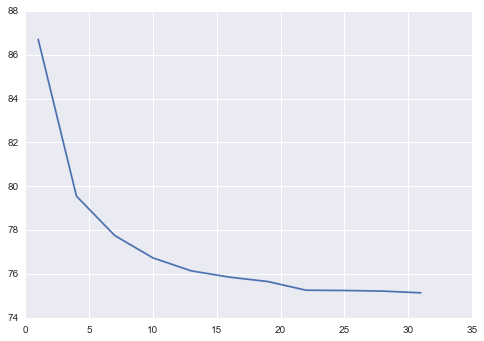

In [18]:
# Let's try searching over num windows.

nWindows_search = np.arange(1, 32, 3)
param = 15
smapes = []
model = Pipeline([ ('features', FunctionTransformer(all_features)),
                   ('tree', DecisionTreeRegressor(max_depth = 10)) ])

for nWindows in nWindows_search:
    Z_train = Ztransform(Y_train, param)
    Z_valid = Ztransform(Y_valid, param)
    model.set_params(features__kw_args = {'nWindows' : nWindows, 'windowSize' : int(480 / nWindows)})
    model.fit(X_train, Z_train)
    Z_predict = model.predict(X_valid)
    Y_predict = inverseZ(Z_predict, param)
    newsmape = smape(1e-6 + Y_predict, Y_valid)
    print('nWindows', nWindows, '\tsmape = ', newsmape, end = '')
    smapes.append(newsmape)
plt.plot(nWindows_search, smapes)
plt.show()

In [17]:
# Let's do a test for all features.

model = Pipeline([ ('features', FunctionTransformer(all_features)),
                   ('tree', DecisionTreeRegressor(max_depth = 10)) ])

Z_trainvalid = Ztransform(Y_trainvalid, param)
Z_test = Ztransform(Y_test, param)
model.set_params(features__kw_args = {'nWindows' : 15, 'windowSize' : int(480 / 15)})
model.fit(X_trainvalid, Z_trainvalid)
Z_predict = model.predict(X_test)
Y_predict = inverseZ(Z_predict, param)
newsmape = smape(1e-6 + Y_predict, Y_test)
print('smape = ', newsmape)

smape =  75.1106221495


nWindows 1 	smape =  87.5401252551nWindows 4 	smape =  80.1515758256nWindows 7 	smape =  78.0940847983nWindows 10 	smape =  77.1077125287nWindows 13 	smape =  76.4182399584nWindows 16 	smape =  76.1949216112nWindows 19 	smape =  75.5396731757nWindows 22 	smape =  75.8071700434nWindows 25 	smape =  75.655366384nWindows 28 	smape =  75.459953413nWindows 31 	smape =  75.4394677405

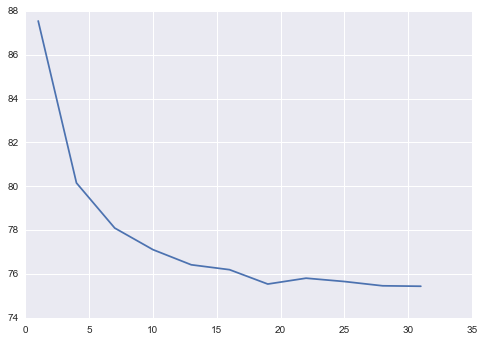

In [29]:
# Let's try searching over num windows for Z transform based on Cauchy Schwarz Upper Bound for SMAPE terms.

nWindows_search = np.arange(1, 32, 3)
param = 1250
smapes = []
model = Pipeline([ ('features', FunctionTransformer(all_features)),
                   ('drop', FunctionTransformer(lambda X : X[:, 3:])),
                   ('tree', DecisionTreeRegressor(max_depth = 10)) ])

epsilon = 1e-6
def Ztransform(Y, param):
    return (np.sqrt(Y) - np.sqrt(param)) / np.sqrt(Y + param)
           
def inverseZ(Z, param):
    result = -1 - Z * np.sqrt(2  - Z**2)
    result /= Z**2 - 1 + epsilon
    result = param * result**2
    return result

for nWindows in nWindows_search:
    Z_train = Ztransform(Y_train, param)
    Z_valid = Ztransform(Y_valid, param)
    model.set_params(features__kw_args = {'nWindows' : nWindows, 'windowSize' : int(480 / nWindows)})
    model.fit(X_train, Z_train)
    Z_predict = model.predict(X_valid)
    Y_predict = inverseZ(Z_predict, param)
    newsmape = smape(1e-6 + Y_predict, Y_valid)
    print('nWindows', nWindows, '\tsmape = ', newsmape, end = '')
    smapes.append(newsmape)
plt.plot(nWindows_search, smapes)
plt.show()

nWindows 1 	smape =  87.6012606062nWindows 4 	smape =  79.6894351621nWindows 7 	smape =  77.8164525659nWindows 10 	smape =  76.8907855046nWindows 13 	smape =  76.0794443815nWindows 16 	smape =  75.9208452218nWindows 19 	smape =  75.5389567272nWindows 22 	smape =  75.2551551939nWindows 25 	smape =  75.3284048909nWindows 28 	smape =  75.3217587653nWindows 31 	smape =  75.123244648

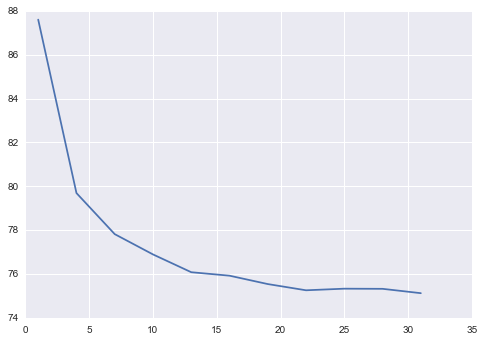

In [14]:
# Let's try searching over num windows for just window features.

nWindows_search = np.arange(1, 32, 3)
param = 15
smapes = []
model = Pipeline([ ('drop', FunctionTransformer(lambda X : X[:, 4:])),
                   ('features', FunctionTransformer(all_window_features)),
                   ('tree', DecisionTreeRegressor(max_depth = 10)) ])

for nWindows in nWindows_search:
    Z_train = Ztransform(Y_train, param)
    Z_valid = Ztransform(Y_valid, param)
    model.set_params(features__kw_args = {'nWindows' : nWindows, 'windowSize' : int(480 / nWindows)})
    model.fit(X_train, Z_train)
    Z_predict = model.predict(X_valid)
    Y_predict = inverseZ(Z_predict, param)
    newsmape = smape(1e-6 + Y_predict, Y_valid)
    print('nWindows', nWindows, '\tsmape = ', newsmape, end = '')
    smapes.append(newsmape)
plt.plot(nWindows_search, smapes)
plt.show()

In [16]:
# Let's do a test for just window_features and decision tree.

model = Pipeline([ ('drop', FunctionTransformer(lambda X : X[:, 4:])),
                   ('features', FunctionTransformer(all_window_features)),
                   ('tree', DecisionTreeRegressor(max_depth = 10)) ])

Z_trainvalid = Ztransform(Y_trainvalid, param)
Z_test = Ztransform(Y_test, param)
model.set_params(features__kw_args = {'nWindows' : 15, 'windowSize' : int(480 / 15)})
model.fit(X_trainvalid, Z_trainvalid)
Z_predict = model.predict(X_test)
Y_predict = inverseZ(Z_predict, param)
newsmape = smape(1e-6 + Y_predict, Y_test)
print('smape = ', newsmape)

smape =  75.1365991794


nWindows 1 	smape =  87.5453990734nWindows 4 	smape =  79.6654464599nWindows 7 	smape =  77.782151423nWindows 10 	smape =  76.8874860393nWindows 13 	smape =  76.0191753359nWindows 16 	smape =  75.6796419306nWindows 19 	smape =  75.4809068764nWindows 22 	smape =  75.3246781839nWindows 25 	smape =  75.1652204717nWindows 28 	smape =  75.4205514401nWindows 31 	smape =  75.2017426138

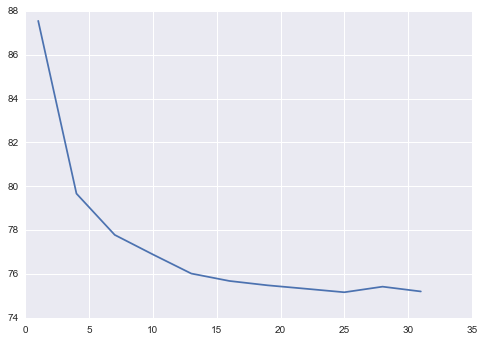

In [22]:
# Let's just try windows and whether it contains a year.

nWindows_search = np.arange(1, 32, 3)
#param = 15
param1 = 50
param2 = 0.1
smapes = []
model = Pipeline([ ('features', FunctionTransformer(all_features)),
                   ('drop', FunctionTransformer(lambda X : X[:, 3:])),
                   ('tree', DecisionTreeRegressor(max_depth = 10)) ])

def Ztransform(Y, param1, param2):
    return 1 / (param1 + Y)**param2

def inverseZ(Z, param1, param2):
    return -param1 + 1 / Z**(1/param2)

Z_train = Ztransform(Y_train, param1, param2)
Z_valid = Ztransform(Y_valid, param1, param2)
    
for nWindows in nWindows_search:
    model.set_params(features__kw_args = {'nWindows' : nWindows, 'windowSize' : int(480 / nWindows)})
    model.fit(X_train, Z_train)
    Z_predict = model.predict(X_valid)
    Y_predict = inverseZ(Z_predict, param1, param2)
    newsmape = smape(1e-6 + Y_predict, Y_valid)
    print('nWindows', nWindows, '\tsmape = ', newsmape, end = '')
    smapes.append(newsmape)
plt.plot(nWindows_search, smapes)
plt.show()

nWindows 1 	smape =  86.8952846696nWindows 4 	smape =  79.7901072497nWindows 7 	smape =  78.1615172881nWindows 10 	smape =  77.2388145304nWindows 13 	smape =  76.5206085132nWindows 16 	smape =  76.1729946476nWindows 19 	smape =  75.4592482461nWindows 22 	smape =  75.8792366403nWindows 25 	smape =  75.7299141562nWindows 28 	smape =  75.6270189227nWindows 31 	smape =  75.4547838035

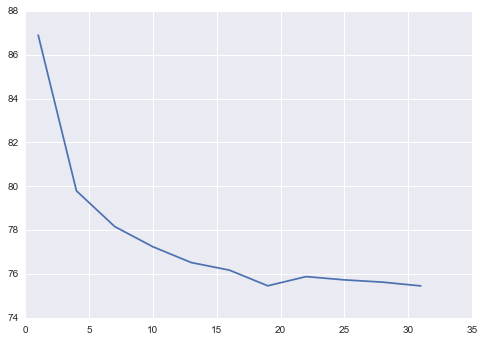

In [31]:
# Let's add in a sort of window_means

nWindows_search = np.arange(1, 32, 3)
param = 1250
smapes = []
sort = FunctionTransformer()
model = Pipeline([ ('features', FunctionTransformer(all_features)),
                   ('sort', sort),
                   ('tree', DecisionTreeRegressor(max_depth = 10)) ])

epsilon = 1e-6
def Ztransform(Y, param):
    return (np.sqrt(Y) - np.sqrt(param)) / np.sqrt(Y + param)
           
def inverseZ(Z, param):
    result = -1 - Z * np.sqrt(2  - Z**2)
    result /= Z**2 - 1 + epsilon
    result = param * result**2
    return result

Z_train = Ztransform(Y_train, param)
Z_valid = Ztransform(Y_valid, param)

for nWindows in nWindows_search:
    model.set_params(features__kw_args = {'nWindows' : nWindows, 'windowSize' : int(480 / nWindows)})
    sort = FunctionTransformer(lambda X : np.hstack(X[:, 0:4], X[:, 4:4+nWindows][X[:, 4:4+nWinows].sort()],
                                                    X[:, 4+nWindows:]))
    model.fit(X_train, Z_train)
    Z_predict = model.predict(X_valid)
    Y_predict = inverseZ(Z_predict, param)
    newsmape = smape(1e-6 + Y_predict, Y_valid)
    print('nWindows', nWindows, '\tsmape = ', newsmape, end = '')
    smapes.append(newsmape)
plt.plot(nWindows_search, smapes)
plt.show()

In [72]:
# Let's try a neural network.

param = 1250
nWindows = 15
windowSize = int(480 / nWindows)

model = Pipeline([ ('features', FunctionTransformer(all_features, kw_args = 
                                                   {'nWindows' : nWindows, 'windowSize' : windowSize})),
                   ('scaler', StandardScaler()),
                   ('neural', MLPRegressor(verbose = True, learning_rate = 'adaptive')) ])

epsilon = 1e-6
def Ztransform(Y, param):
    return (np.sqrt(Y) - np.sqrt(param)) / np.sqrt(Y + param)
           
def inverseZ(Z, param):
    # First, force Z to be in the domain of the inverse function.
    Z = np.maximum(Z, -1)
    Z = np.minimum(Z, +1)
    result = -1 - Z * np.sqrt(2  - Z**2)
    result /= Z**2 - 1 + epsilon
    result = param * result**2
    return result

Z_train = Ztransform(Y_train, param)
Z_valid = Ztransform(Y_valid, param)

model.fit(X_train, Z_train)
Z_predict = model.predict(X_valid)
Y_predict = inverseZ(Z_predict, param)
newsmape = smape(1e-6 + Y_predict, Y_valid)
print('smape = ', newsmape)

Iteration 1, loss = 0.09891476
Iteration 2, loss = 0.03924351
Iteration 3, loss = 0.03018501
Iteration 4, loss = 0.02791430
Iteration 5, loss = 0.02658305
Iteration 6, loss = 0.02451052
Iteration 7, loss = 0.02367959
Iteration 8, loss = 0.02229360
Iteration 9, loss = 0.02156840
Iteration 10, loss = 0.02163310
Iteration 11, loss = 0.02324822
Iteration 12, loss = 0.02052781
Iteration 13, loss = 0.02007453
Iteration 14, loss = 0.01996091
Iteration 15, loss = 0.01937278
Iteration 16, loss = 0.01934396
Iteration 17, loss = 0.01936209
Iteration 18, loss = 0.01835026
Iteration 19, loss = 0.01843883
Iteration 20, loss = 0.01847123
Iteration 21, loss = 0.01830206
Training loss did not improve more than tol=0.000100 for two consecutive epochs. Stopping.
smape =  86.0665344027
